In [13]:
import random
from langgraph.graph import START,END,StateGraph
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, AIMessage
from pydantic import BaseModel,Field
from typing import TypedDict, Literal
import os


In [2]:
from langchain.chat_models import init_chat_model
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv("groq_api")

#Model Initialization:
groq_model = init_chat_model("groq:qwen/qwen3-32b")
groq_model.profile

{'max_input_tokens': 131072,
 'max_output_tokens': 16384,
 'image_inputs': False,
 'audio_inputs': False,
 'video_inputs': False,
 'image_outputs': False,
 'audio_outputs': False,
 'video_outputs': False,
 'reasoning_output': True,
 'tool_calling': True}

In [23]:
from langchain.tools import tool

@tool
def mulitply(a:int,b:int)->int:
    """Multiply the two numbers"""
    return a*b

llm_with_tools = groq_model.bind_tools([mulitply])


In [3]:
class JourneyState(BaseModel):
    current_loc : str = Field(description="Current Location")

In [4]:
def coimbatore(state: JourneyState)->dict:
    print("Staring Journey from Coimbatore")
    return {'current_loc' : 'Departed from Coimbatore'}

def trichy(state: JourneyState)->dict:
    print("Arrived at Journey")
    return {'current_loc' : 'Visited Trichy'}

def salem(state: JourneyState)->dict:
    print("Arrived at Salem")
    return {'current_loc' : 'Visted Salem'}

In [5]:
def decide_intermediate(state: JourneyState)->Literal["trichy","salem"]:
    print(f"Deciding Intermediate from Journey {state.current_loc}")
    if random.random() < 0.5:
        print("----> Route selected: Trichy")
        return "trichy"
    else:
        print("----> Route selected: Salem")
        return "salem"

In [6]:
builder = StateGraph(JourneyState)

#Adding Nodes:
builder.add_node("coimbatore", coimbatore)
builder.add_node("trichy", trichy)
builder.add_node("salem", salem)

#Building Edges:
builder.add_edge(START, "coimbatore")
builder.add_conditional_edges("coimbatore", decide_intermediate)
builder.add_edge("trichy", END)
builder.add_edge("salem", END)

graph = builder.compile()

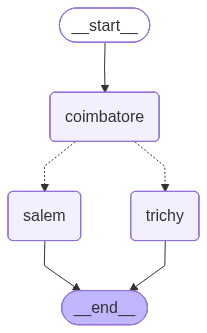

In [10]:
from IPython.display import Image, display
display(graph)

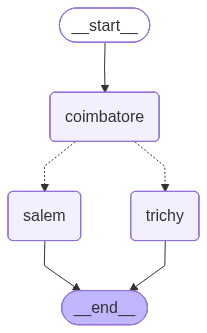

In [11]:
Image(graph.get_graph().draw_mermaid_png())

In [12]:
graph.invoke({"current_loc": "coimbatore"})

Staring Journey from Coimbatore
Deciding Intermediate from Journey Departed from Coimbatore
----> Route selected: Salem
Arrived at Salem


{'current_loc': 'Visted Salem'}

In [16]:
messages = []
messages.append(HumanMessage("Tell about yourself",name = "Gaja"))
messages.append(AIMessage("I am Groq powered Qwen LLM",name = "Qwen"))
for message in messages:
    print(message.pretty_print())

================================ Human Message =================================
Name: Gaja

Tell about yourself
None
================================== Ai Message ==================================
Name: Qwen

I am Groq powered Qwen LLM
None


In [2]:
from langgraph import graph

a = [i for i in dir(graph) if not i.startswith('_')]
a

['END',
 'MessageGraph',
 'MessagesState',
 'START',
 'StateGraph',
 'add_messages',
 'message',
 'state']

In [25]:
from langgraph.graph import MessagesState
class MesssagesState(MessagesState):
    pass

def tool_calling(state:MesssagesState):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}


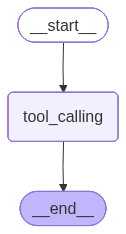

In [29]:
#Graph Creation:
builder = StateGraph(MesssagesState)
builder.add_node("tool_calling", tool_calling)
builder.add_edge(START, "tool_calling")
builder.add_edge("tool_calling", END)
graph = builder.compile()
display(graph)

In [35]:
messages = graph.invoke({"messages":HumanMessage("what is 56 multiplied by 37", name = "Gaja")})
for m in messages['messages']:
    print(m.pretty_print())

================================ Human Message =================================
Name: Gaja

what is 56 multiplied by 37
None
================================== Ai Message ==================================
Tool Calls:
  mulitply (53bjx55ca)
 Call ID: 53bjx55ca
  Args:
    a: 56
    b: 37
None


In [55]:
messages['messages'][-1].usage_metadata['output_token_details']['reasoning']

89